In this notebook, we work through section 3 of __Neubig, G. (2017). Neural machine translation and sequence-to-sequence models: A tutorial. arXiv preprint arXiv:1703.01619__. 

A nice reference that lays out the foundations of SMT is __Della Pietra, V. J. (1994). The mathematics of statistical machine translation: Parameter estimation. Using Large Corpora, 223__ . 

## Statistical Machine Translation

Neural machine translation (NMT) is a subset of the broader framework of statistical machine translation (SMT). Consider two languages $\mathcal{E}$ (e.g., English) and $\mathcal{F}$ (e.g., French) to be sets finite strings with elements in some discrete vocabularies $\mathcal{V}_{\mathcal{E}}$ and $\mathcal{V}_{\mathcal{F}}$. We consider the outcome or sample space to be $\Omega = \mathcal{E} \otimes \mathcal{F}$. Thus $(e,f) \in \Omega$ is a pair of English and French sentences. 

Suppose our objective is to translate a source sentence $f = (f_1,...,f_m)$ where $f_i \in \mathcal{V}_{\mathcal{F}}$ into an english sentence $e = (e_1,...,e_n)$ where $e_j \in \mathcal{V}_{\mathcal{E}}$. We assume that in the natural world, language data are assumed paired random variables $(E,F)$, generated according to some unknown probability measure $(E,F) \sim \textrm{Pr}_{E \times F}$ that assigns higher probability to translationally equivalent pairs. We assume that the training data $\{(E^{i},F^{i})\}_{i=1}^N$ are independent and identically distributed samples from this unknown probability measure $\textrm{Pr}_{E \times F}$.

More specifically, we are interested in estimating the conditional $E|F$, whose distribution can be formulated via Bayes' theorem as:

$\textrm{Pr}(E=e|F=f) = \frac{ \textrm{Pr}_{E}(E=e) \textrm{Pr}_{F|E}(F=f|E=e)}{\textrm{Pr}_{\mathcal{F}}(F=f)}$

Hence for a given realization $F=f$, we may estimate an optimal $e$ via the Maximum A Posteriori estimate:

$\hat{e} = \textrm{argmax}_e \textrm{Pr}(E=e|F=f)$, 

which is equivalent to,

$\hat{e} = \textrm{argmax}_e  \textrm{Pr}_{E}(E=e) \textrm{Pr}_{F|E}(F=f|E=e)$.

The modeling objective is to build tractable probability models to approximate $E$ and $F|E$. In NMT, these ``tractable models'' correspond to neural networks.

Note that this framework extends far beyond just languages. For example, it seems plausible that any blackbox system that takes as input a signal and outputs another signal could be treated in a similar matter. For some reason, this reminds me of input-output control, e.g., as in Vidyasagar's book.


## N-gram language models

Here we consider $N$-gram Markov models for an individual language $\mathcal{E}$. And our objective is to build a model of $\textrm{Pr}(E=e)$. This is often done by factorizing the sentence $e=(e_1,...,e_T)$ made up of $T$ words in the following manner:

 $\textrm{Pr}(E_1=e_1, ..., E_T = e_T) = \textrm{Pr}(E_1=e_1) \cdot \textrm{Pr}(E_2 = e_2 | E_1=e_1) \cdot ... \cdot \textrm{Pr}(E_T = e_T | E_{T-1} = e_{t-1},...,E_1=e_1)$,

where we have dropped the subscripts of the probability measure for convenience. 

A practical challenge with the above approach is that items being conditioned on continually increase in size. Hence, large sequences with size $T >> 0$ can become unmanageable. To address this, we may make additional assumptions about the above probability model -- specifically, with regard to conditional independence structure. First, as we will show below, we augment the vocabulary with a special token to act as a placeholder/start/stopping indicator. Second, we enforce a context window, whereby the target element is statistically independent of all other elements given the elements within its context window,

In [1]:
import requests
import tarfile
import matplotlib.pyplot as plt
import os
import string
import re
import numpy as np

from typing import List, Dict, Any, Tuple

First, we construct a data module that downloads, loads, and stores the relevant training data. Note that in the example below, we look at the English language. And although we have describe the problem above as an English-French translation, in the example below we look at English-German.

In [2]:
class DataModule:
  '''
  Helper module that downloads, loads, and partitions a paired German-English dataset.
  '''
  url = "http://phontron.com/data/"
  filename = "iwslt-en-de-preprocessed.tar.gz"

  def __init__(self, dir):
      self.dir = dir 
      self.path = self.dir + '/' +self.filename

  def download_data(self):
    # create directories and download dataset
    if not os.path.exists(self.dir):
      os.mkdir(self.dir)
    if not os.path.exists(self.path):
      content = requests.get(self.url + self.filename).content
      with open(self.path, "wb") as f:
        f.write(content)
    with tarfile.open(self.path) as f:
      f.extractall(path=self.dir)
  
  def format(self, line: str) -> List[str]:
    #return line.strip().translate(str.maketrans('', '', string.punctuation)).lower().split() #strip out punctuation and case-sensitivity
    return re.findall(r"[\w']+|[.,!?;]", line) #punctuation gets its own entry, case-sensitivity remains
    

  def setup(self):
    # load data
    ds_train = {}
    ds_valid = {}
    ds_test = {}
    with open(self.dir+'/en-de/train.en-de.en', 'r') as f1:
      ds_train['en'] = [self.format(line) for line in f1]
    with open(self.dir+'/en-de/train.en-de.de', 'r') as f2:
      ds_train['de'] = [self.format(line) for line in f2]
    with open(self.dir+'/en-de/valid.en-de.en', 'r') as f1:
      ds_valid['en'] = [self.format(line) for line in f1]
    with open(self.dir+'/en-de/valid.en-de.de', 'r') as f2:
      ds_valid['de'] = [self.format(line) for line in f2]
    with open(self.dir+'/en-de/test.en-de.en', 'r') as f1:
      ds_test['en'] = [self.format(line) for line in f1]
    with open(self.dir+'/en-de/test.en-de.de', 'r') as f2:
      ds_test['de'] = [self.format(line) for line in f2]
    
    self.train = ds_train
    self.valid = ds_valid
    self.test = ds_test

In [3]:
dir = "/content/data"
dm = DataModule(dir)
dm.download_data()
dm.setup()

In [4]:
#observing what the data looks like
print(dm.train['en'][:10])

[['With', 'vibrant', 'video', 'clips', 'captured', 'by', 'submarines', ',', 'David', 'Gallo', 'takes', 'us', 'to', 'some', 'of', "Earth's", 'darkest', ',', 'most', 'violent', ',', 'toxic', 'and', 'beautiful', 'habitats', ',', 'the', 'valleys', 'and', 'volcanic', 'ridges', 'of', 'the', "oceans'", 'depths', ',', 'where', 'life', 'is', 'bizarre', ',', 'resilient', 'and', 'shockingly', 'abundant', '.'], ['David', 'Gallo', 'This', 'is', 'Bill', 'Lange', '.', "I'm", 'Dave', 'Gallo', '.'], ['And', "we're", 'going', 'to', 'tell', 'you', 'some', 'stories', 'from', 'the', 'sea', 'here', 'in', 'video', '.'], ["We've", 'got', 'some', 'of', 'the', 'most', 'incredible', 'video', 'of', 'Titanic', "that's", 'ever', 'been', 'seen', ',', 'and', "we're", 'not', 'going', 'to', 'show', 'you', 'any', 'of', 'it', '.'], ['The', 'truth', 'of', 'the', 'matter', 'is', 'that', 'the', 'Titanic', 'even', 'though', "it's", 'breaking', 'all', 'sorts', 'of', 'box', 'office', 'records', "it's", 'not', 'the', 'most', 'e

Next, we will construct an $n$-gram model. Recall, $n$-gram models limit their context to the previous $(n-1)$ words. Words further in the past are assumed conditionally independent of the current word given the context.

In [5]:
# As written in the tutorial, several standard for smoothing perform interpolation recursively.
# Hence, when we deal with n-grams, we really want to keep track of all m-grams from m=1,...,n. 


# 
n=2 
a = 0.05
# build vocabulary
vocab = ['<S>', '<E>']+sorted(list(set([word for sublist in dm.train['en'] for word in sublist]))) 
stoi = {s:i for i,s in enumerate(vocab)} #mapping strings to indices
itos = {i:s for s,i in stoi.items()}
vocab_size = len(vocab)

# build counts
counts = {}# dictionary containing counts of all m-gram levels from m=1,...,n.
for m in range(n):
  for sentence in dm.train['en']:
    s = ['<S>'] + sentence + ['<E>'] # start and end symbols
    for jj in zip(*[s[ii:] for ii in range(m+1)]): # sliding a context window across the sentence, the window size is "m"
      mgram = tuple(jj)
      counts[mgram] = counts.get(mgram, 0)+1

# build prob estimates
logprobs = {}

sum_unigrams = sum([v for k,v in counts.items() if len(k)==1]) 
for k,v in counts.items():
  if len(k) == 1: #singletons
    logprobs[k] = np.log(v) - np.log(sum_unigrams)
  else:
    logprobs[k] = np.log(v) - np.log(counts[k[:-1]])

In [6]:
# check
p = np.array( [logprobs[tuple([w])] for w in vocab] )
print( np.exp(p).sum() )

context = ['<S>']
p =  np.array( [logprobs.get( tuple(context+[w]), -np.inf) for w in vocab] )
print( np.exp(p).sum() )

1.0000000000000004
1.0


In [7]:
context = ['<S>','The']
counts.get(tuple(context), 0)

4041

In [8]:
# Assuming n>=2, let's just look at the bigram statistics
bigram_stats = [b[1] for b in counts.items() if len(b[0])==2]
(min(bigram_stats),
 max(bigram_stats),
 sum(bigram_stats)/len(bigram_stats) )

(1, 88929, 4.34032408395664)

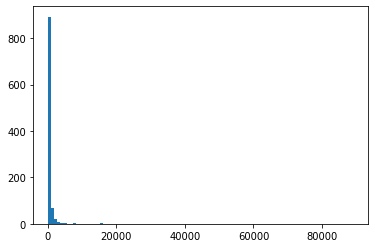

In [9]:
plt.hist(sorted(bigram_stats, reverse=True)[0:1000], bins = 100)
plt.show()

In [10]:
p = np.ones((vocab_size,)) * 1/vocab_size # 0-th order (0-gram) probabilities for smoothing unknowns

context = ['<S>']*(n-1)
for m in range(n):
  logpm = np.array( [logprobs.get(tuple(context+[w])[-1-m:], -np.inf) for w in vocab] )
  p = (1-a) * np.exp( logpm ) + a * p

In [11]:
p.sum()

1.0000000000000002

Based on the $n$-gram counts, we now construct our probabilities. We will use interpolation among probabilities to handle smoothing. This latter aspect is critical. As observed above, language statistics can be extremely sparse -- most of the $n$-grams occur infrequently in the data. Getting good estimates of these probabilities in what are essentially the tail of the distribution is challenging.  


In [24]:
# Packaging the above into a class

class NGram:
  '''
  n-gram class that computes and stores a dictionary of m-gram counts, for m=1,...,n.
  We store all levels of m-grams so that we can perform smoothing, i.e., 
  interpolating probabilities at test time on sentences that did not occur in the training set. 
  '''

  def __init__(self, n: int, x_train: List, a: float):
    self.n = n # n-gram order
    self.x_train = x_train 
    self.a = a #interpolation constant

  def fit(self):
    # build vocabulary
    vocab = ['<S>', '<E>', '<Unk>']+sorted(list(set([word for sublist in self.x_train for word in sublist]))) 

    self.stoi = {s:i for i,s in enumerate(vocab)} #mapping strings to indices
    self.itos = {i:s for s,i in self.stoi.items()}
    self.vocab = vocab
    self.vocab_size = len(vocab)

    # build counts
    counts = {('<Unk>',): 1}# dictionary containing counts of all m-gram levels from m=1,...,n.
    for m in range(self.n):
      for sentence in self.x_train:
        s = ['<S>'] + sentence + ['<E>'] # start and end symbols
        for jj in zip(*[s[ii:] for ii in range(m+1)]): # sliding a context window across the sentence, the window size is "m"
          mgram = tuple(jj)
          counts[mgram] = counts.get(mgram, 0)+1
    
    # build prob estimates
    logprobs = {}

    sum_unigrams = sum([v for k,v in counts.items() if len(k)==1]) 
    for k,v in counts.items():
      if len(k) == 1: #singletons
        logprobs[k] = np.log(v) - np.log(sum_unigrams)
      else:
        logprobs[k] = np.log(v) - np.log(counts[k[:-1]])
    
    self.logprobs = logprobs

  def step(self, context: List[str]):
    # outputs probability distribution over the vocab given the context
    # probabilities recursively interpolated for smoothing
    #assert(len(context) == self.n-1, f'context length should correspond to the previous {self.n-1} words')
    p = np.ones((self.vocab_size,)) * 1/vocab_size # 0-th order (0-gram) probabilities for smoothing
    
    for m in range(self.n):
      logpm = np.array( [self.logprobs.get(tuple(context+[w])[-1-m:], -np.inf) for w in self.vocab] )
      p = (1-self.a) * np.exp( logpm ) + self.a * p
    return p

  def forward(self, seq: List[str]):
    #computes the negative log likelihood of a sequence
    context = ['<S>']*(self.n-1)
    #nseq = len(seq)
    nll = 0
    for w in seq:
      pnext = self.step(context)
      nll -= np.log( pnext[self.stoi.get(w, 2)] ) #If cannot find word w, return the unknown
      context = context[1:]+[w]

    out = nll 
    return out

  def sample(self, seq=None):
    # samples the next value given the context

    if seq == None:
      out = ['<S>']
      context = ['<S>']*(self.n-1)
    else:
      out = seq
      context = [seq[-self.n+m] if  m-self.n >= len(seq) else '<S>' for m in range(self.n) ]
    while out[-1] != '<E>':
      pnext = self.step(context)
      ix = np.random.multinomial(1, pnext).argmax()
      w = self.itos[int(ix)]
      out.append(w)
      context = context[1:]+[w]

    return out

  def __call__(self, seq: List[str]):
    return self.forward(seq)


In [25]:
model = NGram(2, dm.train['en'], 0.05)
model.fit()

In [38]:
# Sampling sequences from the model
nsamp = 10
for ii in range(nsamp):
  s = model.sample()
  print(' '.join(s))

<S> The looking for helping them when Sputnik . It's called Hacking Team has just like it's not negotiate effectively . I'm like Josh and lost when losing an overshoot , not just crossed in my own performances from him in the CEO of course , and obsessive , I would you , and logistical problem for this is strips after the cell in not only one planet today . <E>
<S> They move . <E>
<S> They've never being installed my behavior actually found a tour with other things that has done and we cannot buy still , which speaks . <E>
<S> So <S> It becomes the third . <E>
<S> So what it's true environmental future hold diapers and create foundations for your brain that Americans every year . <E>
<S> And this version of democracy is . <E>
<S> This terrified and they've been separated from the simple parts per capita . <E>
<S> And , bringing their families , if you put in how they may collect extra large figures , this body language we're able to know , we might see here today that very few blocks p

In [34]:
# computing the negative log likelihood on the training data and on the test data.
# here we used a reduced dataset to speed up the evaluation

Xtr = dm.train['en'][:100]
Xte = dm.test['en'][:100]

num_train_words = sum([len(s) for s in Xtr])
num_test_words = sum([len(s) for s in Xte])

nll_train = sum([model(s) for s in Xtr]) / num_train_words
nll_test = sum([model(s) for s in Xte]) / num_test_words

print(f'train nll: {nll_train}, test nll: {nll_test}')

train nll: 4.289743415678976, test nll: 6.144923651011172


For references, a purely random model predicts each word in a sentence independently with probability $1/\textrm{vocab_size}$, which leads to a per-word negative loglikelihood of:

In [33]:
nll_rand = - np.log(1/model.vocab_size)
print(nll_rand)

10.69629905620902


It seems likely that the test negative log likelihood is exaggerated by the presence of words that do not exist in the training set. We have addressed this above by using an "$<\textrm{Unk}>$" symbol to provide support for words not encountered during training. The probability of this special character has been assigned to a very small value. Thus, the negative log likelihood for sentences with unknown words should be very high. As described in Neubig's tutorial, there are many ways of improving on this simple characterization. In the interest of time, however, we will leave it here for now. 